# Traitement - courbe C^infini et bruit gaussien



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from IPython.display import display

In [4]:
path = './Datasets/BSD500_COCO1000_train_val/train/'
img_names = []
color = ('b','g','r')
liste_histr = []
nx = 200

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img = cv.imread(folder+img,cv.IMREAD_COLOR)
        # Etape 1 : obtenir l'histogramme
        for i,col in enumerate(color):
            histr = cv.calcHist([img],[i],None,[256],[0,256]).squeeze()
            # Savitzky-Golay
            y = savgol_filter(histr, 21, 5)
            # interpolation pour nx points
            x = np.linspace(0,1,256, endpoint=True)
            xp = np.linspace(0,1,nx,endpoint=True)
            f = interp1d(x,y)
            yp = f(xp)
            # normalisation
            yp = yp/np.linalg.norm(yp)
            # enregistrement
            liste_histr.append(yp)

#### Méthode filtre Savitzky-Golay

In [5]:
y = histr.copy()
yhat = savgol_filter(y, 21, 5)

In [6]:
plt.plot(yhat)
#plt.plot(y,'+')

#### Fourier

In [7]:
import scipy.fftpack

N = 256
x = np.linspace(0,2*np.pi,256)

w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2

cutoff_idx = spectrum < (spectrum.max()/100)
w2 = w.copy()
w2[cutoff_idx] = 0

yhat2 = scipy.fftpack.irfft(w2)

#### Convolution

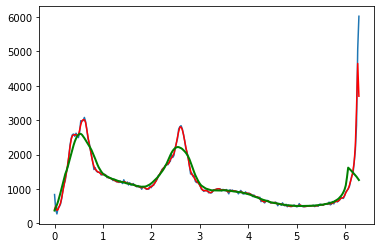

In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


plt.plot(x, y)
plt.plot(x, smooth(y,3), 'r-')
plt.plot(x, smooth(y,19), 'g-', lw=2)

### COMPARAISONS

In [9]:
plt.plot(x, smooth(y,4), 'r-', label= "convolution")
plt.plot(x,yhat, label = "polynome")
plt.plot(x,yhat2, label = "fourrier")
plt.legend()